# ARIMA models I - Addendas
### AJ Zerouali, 2023/05/29

View this as a scrap companion for the main notebook.



## COLAB SETUP

**Mount drive and change PWD**

In [1]:
from google.colab import drive
drive.mount('/content/drive')
%cd drive/MyDrive/Colab\ Notebooks/Time_Series_RL_Research

Mounted at /content/drive
/content/drive/MyDrive/Colab Notebooks/Time_Series_RL_Research


**CRUCIAL - INSTALL REQUIREMENTS**

In [2]:
!chmod 762 pfopt_env_setup.sh
!./pfopt_env_setup.sh

########################################################
########### Setting-up DRL_PFOpt environment ###########
########################################################

###########################
##### Updating PIP... #####
###########################
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/

###############################
##### Updating PyTorch... #####
###############################
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/, https://download.pytorch.org/whl/cu116
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 GB 362.9 kB/s eta 0:00:00
  Attempting uninstall: torch
    Found existing installation: torch 2.0.1+cu118
    Uninstalling torch-2.0.1+cu118:
      Successfully uninstalled torch-2.0.1+cu118
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency

# Imports and helper functions (23/05/26)

In [2]:
# GLOBAL IMPORTS
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from datetime import datetime, timedelta, date
from copy import deepcopy
import gym
# deque and random
from collections import deque
import random
#import sys
import torch as th
from torch import nn
from torch import optim
from drl_pfopt import (PortfolioOptEnv, FeatureEngineer, data_split, AlpacaDownloader, YahooDownloader)
# NOTE 23/05/16 - COLAB version: I've removed the import of sb3-contrib from base_agent.py in drl_pfopt.
# I'm also unable to find a fork of sb3_contrib that's compatible with the sb3 fork
# that I am using right now.
from dual_timeframe_XP import (PFOptDualTFEnv, FeatureEngDualTF, data_dict_split)


/usr/local/lib/python3.9/dist-packages/pyfolio/pos.py:26: UserWarning: Module "zipline.assets" not found; mutltipliers will not be applied to position notionals.
  warnings.warn(


#### Statsmodels imports

In [3]:
# Autocorrelation functions (ACF and PACF plotters)
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
# Augmented Dickey-Fuller test
from statsmodels.tsa.stattools import adfuller 
# Ljung-Box test
from statsmodels.stats.diagnostic import acorr_ljungbox
# SARIMAX model
from statsmodels.tsa.statespace.sarimax import SARIMAX
# ARIMA model (Although we'll just look at the ARMA part)
from statsmodels.tsa.arima_process import ArmaProcess, arma_generate_sample
from statsmodels.tsa.arima.model import ARIMA


In [4]:
from Time_Series_Helpers import get_daily_stock_returns, plot_forecasts

#### Plotting function

It will be useful to have a plotting function for our forecasts. We'll write it so that it also prints out the MSE of the predictions compared to the test data.

In [ ]:
def plot_forecasts(Y_train: np.ndarray,
                   n_train_plot_pts: int,
                   Y_test: np.ndarray,
                   Y_pred: np.ndarray,
                   n_forecast_plot_pts: int,
                   fig_title: str = "Original process and forecasts",
                   legend_loc: int = 1,
                   x_label: str = "Time",
                   y_label: str = "Y",
                   Y_pred_conf_int: np.ndarray = None,
                   plot_confidence_band: bool = False,
                   plot_upper_lower_curves: bool = False,
                  ):
    '''
        :param Y_train: np.ndarray, training data
        :param n_train_pts: int, number of points to plot from training data
        :param Y_test: np.ndarray, test data
        :param Y_pred: np.ndarray, out-of-sample forecasts
        :param n_forecast_pts: int, no. of points to plot from test data and forecasts
        :param fig_title: str, title of the figure
        :param legend_loc: int = 1,
        :param x_label: str = "Time", self-explanatory
        :param y_label: str = "Y", self-explanatory
        :param Y_pred_conf_int: np.ndarray = None, confidence interval start and end points.
                    If Y_pred.shape = (N,), should have Y_pred_conf_int.shape = (N,2),
                    with Y_pred_conf_int[:,0] giving the lower bound of the conf. interval
                    and  Y_pred_conf_int[:,1] giving the upper bound of the conf. interval
        :param plot_confidence_band: bool = False, whether or not to plot the confidence band
        :param plot_upper_lower_curves: bool = False, whetehr or not to not the upper and lower bounds
    '''
    # Initializations
    n_train_pts = len(Y_train)
    n_test_pts = len(Y_test)
    n_forecast_pts = len(Y_pred)
    
    # Check lengths and shapes
    if n_train_pts<n_train_plot_pts:
        raise ValueError(f"n_train_plot_pts = {n_train_plot_pts} is greater than len(Y_train) = {len(Y_train)}")
    if (Y_train.shape != (n_train_pts,)) or (Y_test.shape != (n_test_pts,)) or (Y_pred.shape != (n_forecast_pts,)):
        raise ValueError("The parameters Y_train, Y_test, and Y_pred must all be one-dimensional arrays.")
    if n_forecast_plot_pts>n_forecast_pts:
        raise ValueError(f"n_forecast_plot_pts = {n_forecast_plot_pts} is greater than len(Y_pred) = {len(Y_pred)}")
    if plot_confidence_band:
        if Y_pred_conf_int.shape != (n_forecast_pts,2):
            print(f"WARNING: Will not plot confidence band, param. Y_pred_conf_int has wrong shape.\n"\
                  f"Plotting the confidence band requires Y_pred_conf_int.shape = (len(Y_pred),2)"
                 )
            plot_confidence_band = False
    
    # Make x-axis ranges for sample and out-of-sample data
    #x_plot_start = n_train_pts - n_train_plot_pts
    x_sample = np.arange(n_train_pts - n_train_plot_pts, n_train_pts)
    x_oos_data = np.arange(n_train_pts, n_train_pts+ n_test_pts)
    x_oos_pred = np.arange(n_train_pts, n_train_pts+ n_forecast_plot_pts)
    
    # Init. figure
    fig_pred, ax_pred = plt.subplots()
    
    # Plot the original process (train+test data)
    Y_vals = np.concatenate([Y_train[-n_train_plot_pts:], Y_test], axis = 0)
    x_vals = np.concatenate([x_sample, x_oos_data], axis = 0)
    ax_pred.plot(x_vals, Y_vals, color = 'b', label = 'Original Process')
    
    # Shade the out-of-sample region
    ax_pred.axvspan(n_train_pts, n_train_pts+max(n_test_pts,n_forecast_plot_pts), color='#808080', alpha=0.2)
    
    # Plot the forecats
    ax_pred.plot(x_oos_pred, Y_pred[:n_forecast_plot_pts], color = 'r', label = 'Forecast')
    
    # Plot the confidence band
    if plot_confidence_band:
        if plot_upper_lower_curves:
            # Upper limit of predictions
            ax_pred.plot(x_oos_pred, Y_pred_conf_int[:,1], color = 'g', label = 'Forecast upper lim')
            # Lower limit of predictions
            ax_pred.plot(x_oos_pred, Y_pred_conf_int[:,0], color = 'g', label = 'Forecast lower lim')
        # Shading of the 95% confidence band
        ## Ref: https://matplotlib.org/stable/gallery/lines_bars_and_markers/fill_between_demo.html
        ax_pred.fill_between(x_oos_pred, Y_pred_conf_int[:,0], Y_pred_conf_int[:,1], 
                              color = 'g', alpha=0.35)
    
    # Title, axes and legend
    ax_pred.legend(loc=legend_loc)
    ax_pred.set_xlabel(x_label)
    ax_pred.set_ylabel(y_label)
    ax_pred.set_title(fig_title)
    
    plt.show()
    
    # Compute and display the forecast MSE
    n_pts_mse = min(n_test_pts, n_forecast_pts)
    MSE_pred = ((Y_pred[:n_pts_mse]-Y_test[:n_pts_mse])**2).mean()
    print(f"MSE over first {n_pts_mse} points of Y_test and Y_pred:\n"\
          f"MSE(Y_pred[:{n_pts_mse}],Y_test[:{n_pts_mse}]) = {MSE_pred}"
         )
    

## Stock close returns function

In [ ]:
from drl_pfopt.common.data.data_utils import get_timeframe_info, get_market_calendar_day_list

In [ ]:
def get_daily_stock_returns(df_data: pd.DataFrame,
                            stock_tickers_list: list,
                            start_date: str,
                            end_date: str,
                            log_returns: bool = False
                           ):
    '''
        Function that isolates the close returns of a list
        of tickers from a dataframe. Returns a dataframe of 
        daily close prices and a dataframe of daily returns
        or log returns of the close prices.
        NOTES: 
        - The df_data parameter is assumed to be built
          by the drl_pfopt AlpacaDownloader.
        - If the dataframe is not on a daily timeframe for
          the data, this function will assign the close prices
          at 16:00 for the daily close prices. These timestamps must be
          in the "date" column of df_data.
        - The close price returns ARE NOT in percentage.
            
        :param df_data: pd.DataFrame. Should be produced by an object
                    of class drl_pfopt.common.data.downloaders.AlpacaDownloader.
        :param stock_tickers_list: list of stock tickers.
        :param start_date: str, start date in "%Y-%m-%d" format
        :param end_date: str, INCLUSIVE end date in "%Y-%m-%d" format
        :param log_returns: bool, False by default. Whether to compute
                    log returns instead of returns.
                    
        :return df_returns: pd.DataFrame of daily close price returns
                or log returns.
        :return df_close: pd.DataFrame of daily close prices.

    '''
    # Sort the tickers list
    stock_tickers_list.sort()
    
    # Check dataset contains the stock ticker selected
    data_ticker_list = list(df_data.tic.unique())
    for tic in stock_tickers_list:
        if tic not in list(df_data.tic.unique()):
            raise ValueError(f"ERROR: Ticker {tic} not found in df_data.")
    # Check dates are consistent with dataset
    data_timestamp_list = list(df_data.date.unique())
    data_start_date = data_timestamp_list[0][:10]
    data_end_date = data_timestamp_list[-1][:10]
    if end_date<= start_date:
        raise ValueError(f"ERROR: start_date={start_dat} parameter cannot be after end_date={end_date}.")
    if (end_date > data_end_date) or (end_date < data_start_date)\
        or (start_date > data_end_date) or (start_date < data_start_date):
        raise ValueError(f"ERROR: start_date and end_date are not in the dataset df_data."\
                         f"The dataset has: data_start_date = {data_start_date}, data_end_date = {data_end_date}."
                        )
        
    # Get data timeframe info dictionary
    data_timeframe_info = get_timeframe_info(data_timestamp_list)
    data_day_list_ = data_timeframe_info["day_list"] 
    
    # Get output day list (str and datetime formats)
    start_date_ = datetime.strptime(start_date, "%Y-%m-%d")
    end_date_ = datetime.strptime(end_date, "%Y-%m-%d")
    ### Temporary day_list
    day_list_ = get_market_calendar_day_list(start_date_, end_date_+timedelta(days = 10))
    last_day_idx = day_list_.index(end_date_) # .index() 
    ## Final day list
    day_list = [x.strftime("%Y-%m-%d") for x in day_list_[:last_day_idx+1]]
    
    # Get list of close timestamps for dataset
    if data_timeframe_info["timeframe"] == "Day":
        close_timestamps_list = day_list
    else:
        close_timestamps_list = [x+" 16:00" for x in day_list]
            
    # Reduce dataframe
    df_X = df_data.copy()
    ### Keep tickers in stock_tickers_list
    df_X = df_X[df_X.tic.isin(stock_tickers_list)]
    ### Keep timestamps in close_timestamps_list
    df_X = df_X[df_X.date.isin(close_timestamps_list)]
    df_X = df_X.sort_values(["date", "tic"], ignore_index=True)
    
    # Make close prices dataframe
    #df_close = df_X.pivot_table(index = 'date', columns = 'tic', values = 'close')
    df_close = pd.DataFrame({'date': day_list})
    for tic in stock_tickers_list:
        df_close[tic] = df_X[(df_X.tic==tic)]['close'].to_numpy() # Bugs if you remove to_numpy()
    np_close = df_close[stock_tickers_list].to_numpy()
    
    # Make returns array
    np_returns = np.zeros(shape = np_close.shape)
    np_returns[1:,:] = (np_close[1:,:]-np_close[:-1,:])/np_close[:-1,:]
    if log_returns:
        np_returns = np_returns + np.ones(shape = np_returns.shape)
        np_returns = np.log(np_returns)
        
    # Make returns dataframe
    df_returns = pd.DataFrame({'date': day_list})
    for i in range(len(stock_tickers_list)):
        df_returns[stock_tickers_list[i]] = np_returns[:,i]
    
    return df_returns, df_close
    
    

### **TESTS**

In [ ]:
# Load DJIA file 
df_Alpaca_15min = pd.read_csv(filepath_or_buffer="datasets/Alpaca_DJIA_15min_2208-2211.csv",
                           usecols = ['date', 'open', 'high', 'low', 'close', 'volume', 'tic'])
TICKER_LIST = ['AXP', 'BA', 'CVX', 'JNJ', 'KO']


# Reduce to 10 stocks
df_file = df_Alpaca_15min[df_Alpaca_15min.tic.isin(TICKER_LIST)].copy()
del df_Alpaca_15min

In [ ]:
timeframe_info_dict = get_timeframe_info(list(df_file.date.unique()))

In [ ]:
print("Data start:")
print(timeframe_info_dict["start_date"])
print("Data end:")
print(timeframe_info_dict["end_date"])

Data start:
2022-08-01 00:00:00
Data end:
2022-11-01 00:00:00


In [ ]:
df_file[(df_file.date>="2022-08-02") & (df_file.date<"2022-08-05")]

,date,open,high,low,close,volume,tic
1832,2022-08-02 08:00,153.33,153.33,153.33,153.33,33.0,AXP
1833,2022-08-02 08:00,169.06,169.06,169.06,169.06,162.0,BA
1837,2022-08-02 08:00,160.80,160.98,160.80,160.98,1006.0,CVX
1845,2022-08-02 08:00,173.91,173.91,173.91,173.91,10.0,JNJ
1847,2022-08-02 08:00,64.60,64.60,64.60,64.60,403.0,KO
...,...,...,...,...,...,...,...
7292,2022-08-04 23:00,156.87,156.87,156.87,156.87,8.0,AXP
7293,2022-08-04 23:00,166.60,166.60,166.60,166.60,200.0,BA
7297,2022-08-04 23:00,151.14,151.14,150.90,150.90,440.0,CVX
7305,2022-08-04 23:00,171.79,171.79,171.79,171.79,5.0,JNJ


In [ ]:
ticker_list = ["JNJ", "BA"]
df_returns, df_close = get_daily_stock_returns(df_data = df_file,
                                               stock_tickers_list=ticker_list,
                                               start_date = "2022-08-02",
                                               end_date = "2022-08-04",
                                               log_returns = False,)

In [ ]:
df_returns

,date,BA,JNJ
0,2022-08-02,0.000000,0.000000
1,2022-08-03,-0.008254,-0.000858
2,2022-08-04,0.011148,-0.010535


In [ ]:
df_close

,date,BA,JNJ
0,2022-08-02,165.975,174.80
1,2022-08-03,164.605,174.65
2,2022-08-04,166.440,172.81


In [ ]:
df_file[(df_file.tic.isin(ticker_list))&\
        (df_file.date.isin(close_timestamps_list))]\
.pivot_table(index = 'date', columns = 'tic', values = 'close')

tic,BA,JNJ
date,,
2022-08-02 16:00,165.975,174.80
2022-08-03 16:00,164.605,174.65
2022-08-04 16:00,166.440,172.81


In [ ]:
# Seriously. Fuck Pandas until the end of times.
df_data = df_file
stock_tickers_list = ticker_list
start_date = "2022-08-02"
end_date = "2022-08-04"

if True:
    # Sort the tickers list
    stock_tickers_list.sort()
    
    # Check dataset contains the stock ticker selected
    data_ticker_list = list(df_data.tic.unique())
    for tic in stock_tickers_list:
        if tic not in list(df_data.tic.unique()):
            raise ValueError(f"ERROR: Ticker {tic} not found in df_data.")
    # Check dates are consistent with dataset
    data_timestamp_list = list(df_data.date.unique())
    data_start_date = data_timestamp_list[0][:10]
    data_end_date = data_timestamp_list[-1][:10]
    if end_date<= start_date:
        raise ValueError(f"ERROR: start_date={start_dat} parameter cannot be after end_date={end_date}.")
    if (end_date > data_end_date) or (end_date < data_start_date)\
        or (start_date > data_end_date) or (start_date < data_start_date):
        raise ValueError(f"ERROR: start_date and end_date are not in the dataset df_data."\
                         f"The dataset has: data_start_date = {data_start_date}, data_end_date = {data_end_date}."
                        )
        
    # Get data timeframe info dictionary
    data_timeframe_info = get_timeframe_info(data_timestamp_list)
    data_day_list_ = data_timeframe_info["day_list"] # Needed?
    
    # Get output day list (str and datetime formats)
    start_date_ = datetime.strptime(start_date, "%Y-%m-%d")
    end_date_ = datetime.strptime(end_date, "%Y-%m-%d")
    ### Temporary day_list
    day_list_ = get_market_calendar_day_list(start_date_, end_date_+timedelta(days = 10))
    last_day_idx = day_list_.index(end_date_)
    ## Final day list
    day_list = [x.strftime("%Y-%m-%d") for x in day_list_[:last_day_idx+1]]
    
    # Get list of close timestamps for dataset
    if data_timeframe_info["timeframe"] == "Day":
        close_timestamps_list = day_list
    else:
        close_timestamps_list = [x+" 16:00" for x in day_list]
            
    # Reduce dataframe
    df_X = df_data.copy()
    ### Keep tickers in stock_tickers_list
    df_X = df_X[df_X.tic.isin(stock_tickers_list)]
    ### Keep timestamps in close_timestamps_list
    df_X = df_X[df_X.date.isin(close_timestamps_list)]
    df_X = df_X.sort_values(["date", "tic"], ignore_index=True)

In [ ]:
day_list_

[datetime.datetime(2022, 8, 2, 0, 0),
 datetime.datetime(2022, 8, 3, 0, 0),
 datetime.datetime(2022, 8, 4, 0, 0),
 datetime.datetime(2022, 8, 5, 0, 0),
 datetime.datetime(2022, 8, 8, 0, 0),
 datetime.datetime(2022, 8, 9, 0, 0),
 datetime.datetime(2022, 8, 10, 0, 0),
 datetime.datetime(2022, 8, 11, 0, 0),
 datetime.datetime(2022, 8, 12, 0, 0)]

In [ ]:
end_date_

datetime.datetime(2022, 8, 4, 0, 0)

In [ ]:
day_list_.index(end_date_)

2

In [ ]:
last_day_idx

2

In [ ]:
idx = day_list_.index(end_date_)

In [ ]:
idx

2

In [ ]:
day_list_[last_day_idx]

datetime.datetime(2022, 8, 5, 0, 0)

In [ ]:
df_X

,date,open,high,low,close,volume,tic
0,2022-08-02 16:00,165.900,166.1300,165.89,165.975,10389.0,BA
1,2022-08-02 16:00,174.860,174.8900,174.80,174.800,8586.0,JNJ
2,2022-08-03 16:00,164.645,164.6625,164.45,164.605,15846.0,BA
3,2022-08-03 16:00,174.690,174.7200,174.65,174.650,7799.0,JNJ
4,2022-08-04 16:00,166.350,166.5200,166.32,166.440,13396.0,BA
5,2022-08-04 16:00,172.890,172.9300,172.81,172.810,5496.0,JNJ


In [ ]:
if True:
        # Make close prices dataframe
    #df_close = df_X.pivot_table(index = 'date', columns = 'tic', values = 'close')
    df_close = pd.DataFrame({'date': day_list})
    for tic in stock_tickers_list:
        df_close[tic] = df_X[(df_X.tic==tic)]['close']
    np_close = df_close[stock_tickers_list].to_numpy()

In [ ]:
df_close

,date,BA,JNJ
0,2022-08-02,165.975,NaN
1,2022-08-03,NaN,174.8


In [ ]:
tic = 'JNJ'
df_X[df_X.tic==tic]['close']

1    174.80
3    174.65
5    172.81
7    170.77
Name: close, dtype: float64

In [ ]:
df_close = pd.DataFrame({'date': day_list})

In [ ]:
df_close

,date
0,2022-08-02
1,2022-08-03
2,2022-08-04
3,2022-08-05


In [ ]:
df_close[tic] = df_X[df_X.tic==tic]['close'].to_numpy()

In [ ]:
df_close

,date,JNJ
0,2022-08-02,174.80
1,2022-08-03,174.65
2,2022-08-04,172.81
3,2022-08-05,170.77


## Q-Q Plots

I wanted to check how to make histograms and get a better understanding of Q-Q plots. You need to call scipy's continuous distributions objects to get the theoretical quantiles of statsmodels' Q-Q plot function. Scipy's documentation is severely lacking and unhelpful.


In [ ]:
from statsmodels.graphics.gofplots import qqplot
from scipy.stats import norm

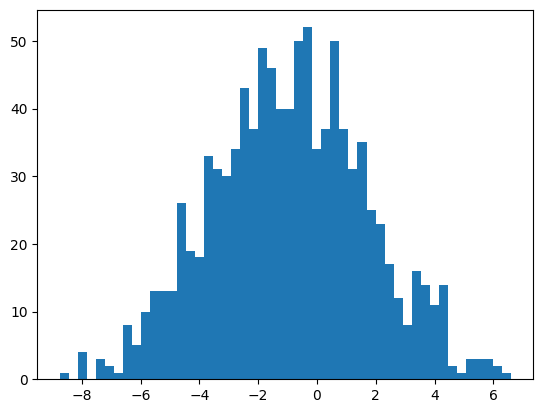

In [ ]:
np.random.seed(101)
N_pts = 1000
X = np.random.normal(loc = -1, scale = 2.5, size = (N_pts,))
X_hist_vals, X_50_bins, _ = plt.hist(X, bins = 50)

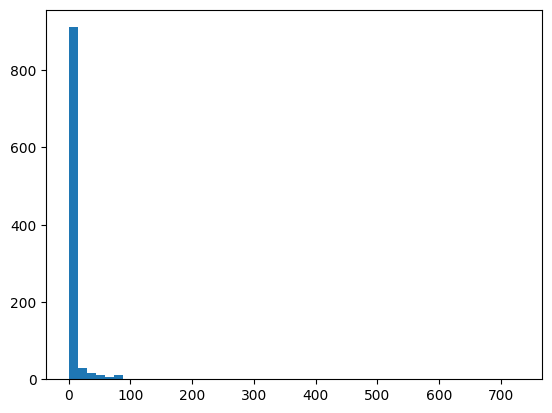

In [ ]:
Y = np.exp(X)
Y_hist_vals, Y_50_bins, _ = plt.hist(Y, bins = 50)

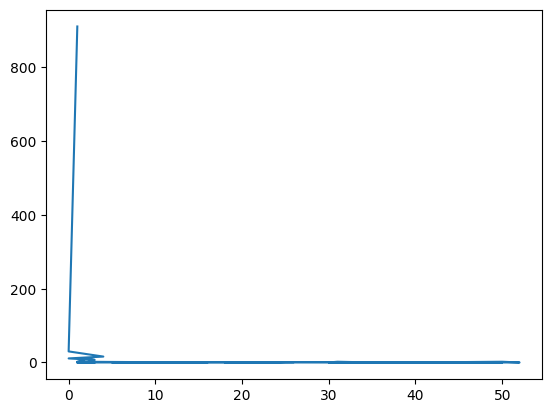

In [ ]:
plt.plot(X_hist_vals, Y_hist_vals)

Compare that distribution to a random normal with *statsmodels*' Q-Q plot:

In [ ]:
std_normal_rv= norm()
normal_rv_ = norm(loc = -1, scale = 2.5)

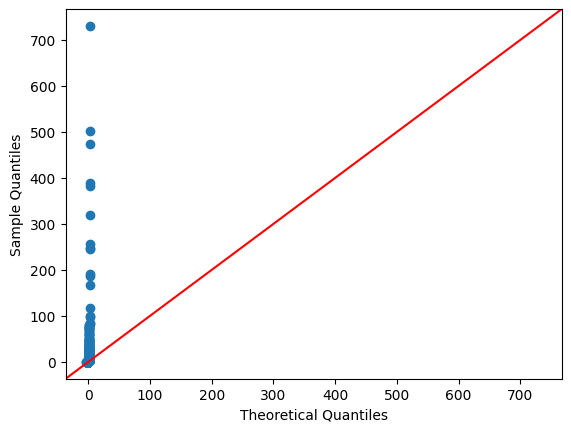

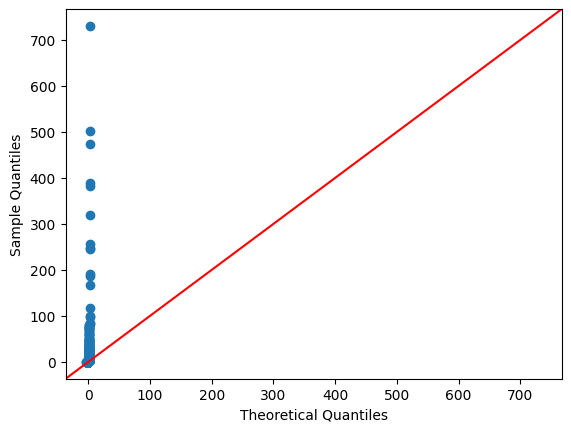

In [ ]:
qqplot(data=np.exp(X), dist = std_normal_rv, line = "45")

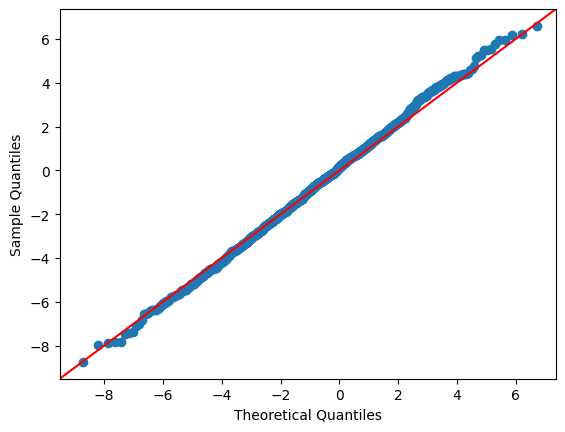

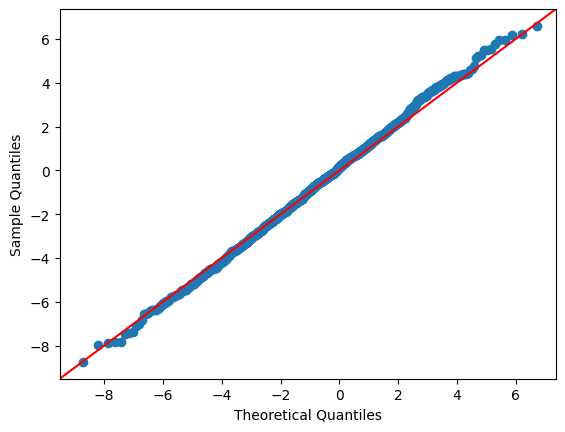

In [ ]:
qqplot(data=X, dist = normal_rv_, line="45")

In [ ]:
normal_rv_.std()

2.5

In [ ]:
std_normal_rv.std()

1.0

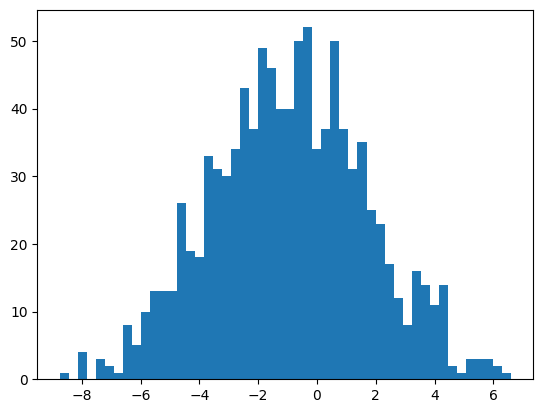

In [ ]:
np.random.seed(101)
N_pts = 1000
X = np.random.normal(loc = -1, scale = 2.5, size = (N_pts,))
X_hist_vals, X_50_bins, _ = plt.hist(X, bins = 50)

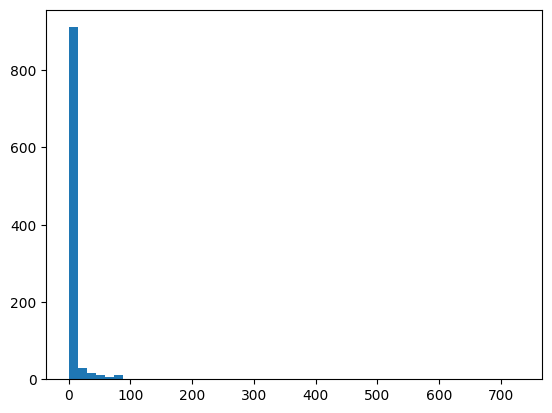

In [ ]:
Y = np.exp(X)
Y_hist_vals, Y_50_bins, _ = plt.hist(Y, bins = 50)

## Stock price modeling example with ARIMA

The steps we'll follow:
1) Get the data and the close returns using the helper function.
2) Test for stationarity.
3) Plot the ACF and PACF to find the range of (p,q) orders to test.
4) Fit the time series to the list of $ARMA(p,q)$ processes and compute the AIC.
5) Get the lowest AIC model and extract residuals.
6) Plot fitting diagnostics for the QQ-plot.
7) Apply the Ljung-Box test to the residuals.

We will work with the "JNJ" stock.

### (1) Obtaining the time series

In [ ]:
from Time_Series_Helpers import get_daily_stock_returns

In [4]:
# Load DJIA file 
df_Alpaca_15min = pd.read_csv(filepath_or_buffer="datasets/Alpaca_DJIA_15min_2208-2211.csv",
                           usecols = ['date', 'open', 'high', 'low', 'close', 'volume', 'tic'])

# Get close price log returns of JNJ
df_returns, df_close = get_daily_stock_returns(df_data = df_Alpaca_15min,
                                               stock_tickers_list = ["JNJ"],
                                               start_date = "2022-08-01",
                                               end_date = "2022-10-31",
                                               log_returns = True,)


<AxesSubplot: >

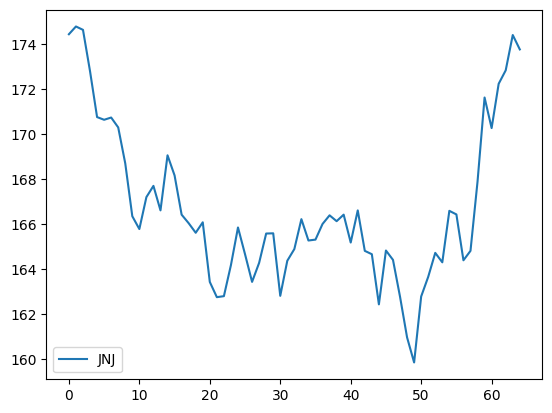

In [5]:
df_close.plot()

In [ ]:
len(df_returns)

65

<AxesSubplot: >

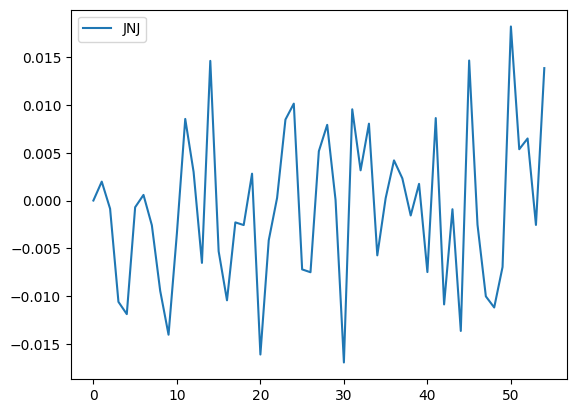

In [6]:
# Get the time series and split into train-test
Y = df_returns["JNJ"].to_numpy()
N_test = 10
Y_train = Y[:-N_test]
Y_test = Y[-N_test:]

# Plot last 20 points of time series
df_returns.iloc[:-N_test].plot()

### (2) Testing for stationarity

As it happens, the log returns **are not** stationary:

In [7]:
# Execute ADF test
Y_ADF, Y_ADF_pval, Y_n_lags, _, _, _ = adfuller(Y_train)
print("Augmented Dickey-Fuller Test results:")
print(f"Y_ADF = {Y_ADF}, Y_ADF_pval = {Y_ADF_pval}, Y_n_lags = {Y_n_lags}")

Augmented Dickey-Fuller Test results:
Y_ADF = -2.3495379865566526, Y_ADF_pval = 0.15648811194090378, Y_n_lags = 5


We get a stationary series by differencing though:

In [8]:
# Difference the log returns
Z_train = np.diff(Y_train)

# Execute ADF test
Z_ADF, Z_ADF_pval, Z_n_lags, _, _, _ = adfuller(Z_train)
print("Augmented Dickey-Fuller Test results:")
print(f"Z_ADF = {Z_ADF}, Z_ADF_pval = {Z_ADF_pval}, Z_n_lags = {Z_n_lags}")

Augmented Dickey-Fuller Test results:
Z_ADF = -8.472045239685661, Z_ADF_pval = 1.468728707971959e-13, Z_n_lags = 3


### (3) ACF and PACF plots

Now we plot the ACF and PACF

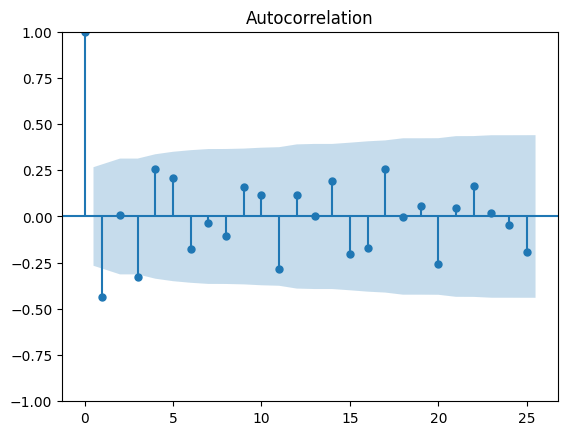

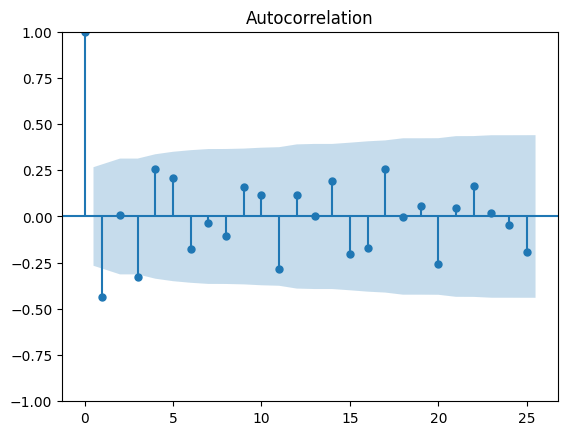

In [ ]:
# Plot ACF
plot_acf(x = Z_train, lags = 25)

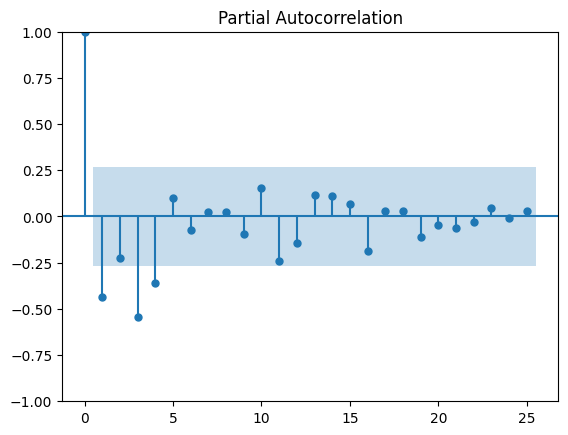

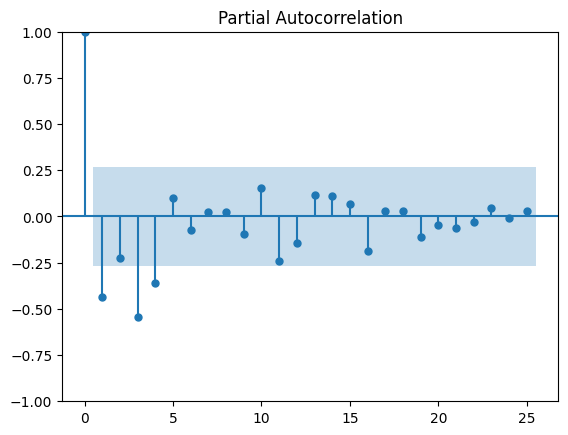

In [ ]:
# Plot PACF
plot_pacf(x = Z_train, lags = 25)

We see sinusoidal and slow decay of lag significance here.

### (4) Grid search on $(p,q)$ parameters

We make a function for this.

In [ ]:
from copy import deepcopy

In [9]:
def ARIMA_grid_search(Y: np.ndarray,
                      p_min: int, 
                      p_max: int,
                      q_min: int,
                      q_max: int,
                     ):
    '''
    '''
    # Make list of (p,q) values
    order_list = []
    for p in range(p_min, p_max+1):
        for q in range(q_min, q_max+1):
            order_list.append((p,q))
    
    # Output initializations
    model_dict = {}
    model_fit_results_dict = {}
    df_results = pd.DataFrame(index=range(len(order_list)),columns = ["p","q","AIC"])
    AIC_list = []
    
    # AIC_dict = {}
    
    # Main loop
    for i in range(len(order_list)):
        # (p,q)
        order = order_list[i]
        p = order[0]
        q = order[1]
        
        # Instantiate temp model
        model_temp = ARIMA(endog = Y,
                           order=(p, 0, q), 
                           trend = 'c')
        ## Store model
        model_dict[order] = deepcopy(model_temp)
        
        # Fit the model
        model_fit_res_temp = model_temp.fit()
        ## Store results obj
        model_fit_results_dict[order] = deepcopy(model_fit_res_temp)
        
        # Get the AIC
        model_aic_temp = model_fit_res_temp.aic
        AIC_list.append(model_aic_temp)
        ### Store in dataframe
        df_results.iloc[i] = pd.Series({"p":p, "q":q, "AIC":model_aic_temp})
        
        # Delete model and results
        del model_temp, model_fit_res_temp
        
    # Get the model with lowest AIC
    np_AIC = df_results["AIC"].to_numpy()
    min_idx = np_AIC.argmin()
    ARIMA_fit = model_fit_results_dict[order_list[min_idx]]
    
    # Finished message
    print(f"Model with minimal AIC is ARIMA({order_list[min_idx][0]},{order_list[min_idx][1]})")
    
    
    return ARIMA_fit, df_results, model_fit_results_dict, model_dict

In [12]:
ARIMA_fit, df_results, model_fit_results_dict, models_dict\
    = ARIMA_grid_search(Y = Z_train,
                        p_min = 0,
                        p_max = 4,
                        q_min = 0,
                        q_max = 3,)

/usr/local/lib/python3.9/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.9/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.9/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertib

Model with minimal AIC is ARIMA(4,0)


/usr/local/lib/python3.9/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [13]:
df_results

,p,q,AIC
0,0.0,0.0,-323.135382
1,0.0,1.0,-347.094758
2,0.0,2.0,-354.442944
3,0.0,3.0,-346.320044
4,1.0,0.0,-332.768911
5,1.0,1.0,-354.032438
6,1.0,2.0,-348.362176
7,1.0,3.0,-349.375052
8,2.0,0.0,-333.538558
9,2.0,1.0,-348.800639


In [14]:
print(ARIMA_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   54
Model:                 ARIMA(4, 0, 0)   Log Likelihood                 185.077
Date:                Mon, 29 May 2023   AIC                           -358.153
Time:                        22:42:36   BIC                           -346.219
Sample:                             0   HQIC                          -353.551
                                 - 54                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0002      0.000      0.692      0.489      -0.000       0.001
ar.L1         -0.9097      0.127     -7.143      0.000      -1.159      -0.660
ar.L2         -0.7503      0.150     -5.013      0.0

We will continue working with the $ARIMA(4,0)$ model.

### (5) Residuals analysis

Here we look at the QQ-plot and perform the Ljung-Box test.

In [ ]:
from statsmodels.stats.diagnostic import acorr_ljungbox

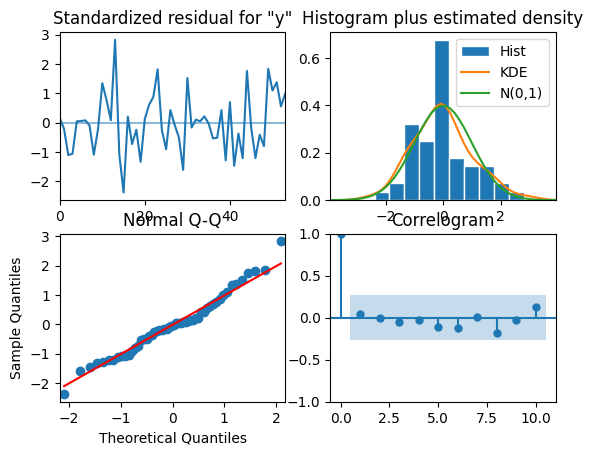

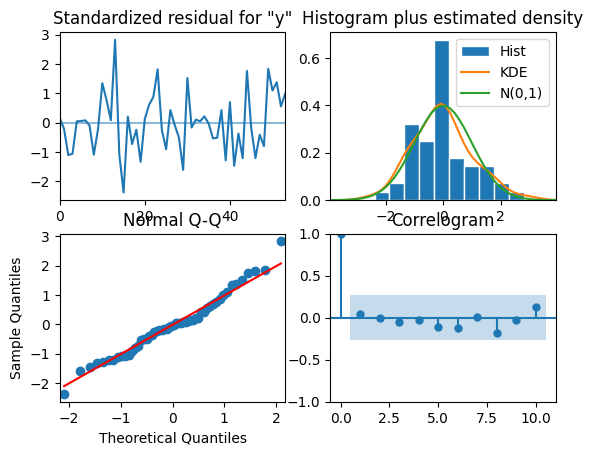

In [16]:
ARIMA_fit.plot_diagnostics()

The quantiles are decently close to the $y=x$ axis.

In [18]:
# Residuals
Z_residuals = ARIMA_fit.resid
print(f"type(Z_residuals) = {type(Z_residuals)}")
print(f"Z_residuals.shape = {Z_residuals.shape}")

type(Z_residuals) = <class 'numpy.ndarray'>
Z_residuals.shape = (54,)


Next, we apply the Ljung-Box test. The documentation is here:

https://www.statsmodels.org/devel/generated/statsmodels.stats.diagnostic.acorr_ljungbox.html

A peculiar point is that

In [21]:
# Including the model param no.
df_LjungBox = acorr_ljungbox(Z_residuals, model_df = 4)

In [22]:
df_LjungBox

,lb_stat,lb_pvalue
1,0.138726,NaN
2,0.145644,NaN
3,0.324445,NaN
4,0.376944,NaN
5,1.091282,0.296187
6,1.879389,0.390747
7,1.880834,0.597504
8,4.322237,0.364149
9,4.404733,0.492730
10,5.445172,0.488108


In [27]:
df_LjungBox = acorr_ljungbox(Z_residuals, lags = len(Z_residuals)-1)

<AxesSubplot: >

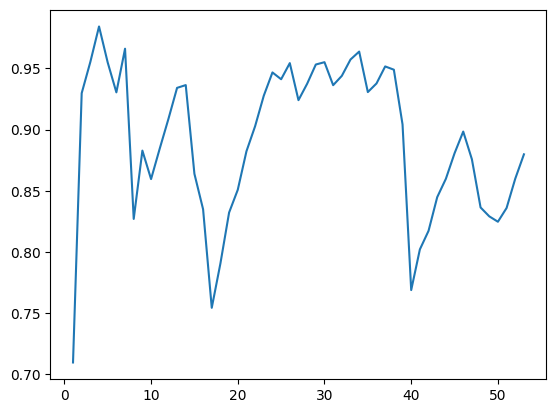

In [28]:
df_LjungBox['lb_pvalue'].plot()

Following Peixeiro, these values are well above 0.05, so we'll assume that our residuals are indeed normal and i.i.d.

### (6) Forecasting the differenced log returns

First, let's make the *Z_test* properly, as numpy shortens the time series by one entry.

In [ ]:
# Add one element to Y_test
Y_test_ = np.empty(shape = (len(Y_test)+1,))
Y_test_[0] = Y_train[-1]
Y_test_[1:] = Y_test

# Difference
Z_test = np.diff(Y_test_)

In [ ]:
# Forecast
ARIMA_pred_res = ARIMA_fit.get_forecast(N_test)
Z_pred = ARIMA_pred_res.predicted_mean
Z_pred_conf_int = ARIMA_pred_res.conf_int()

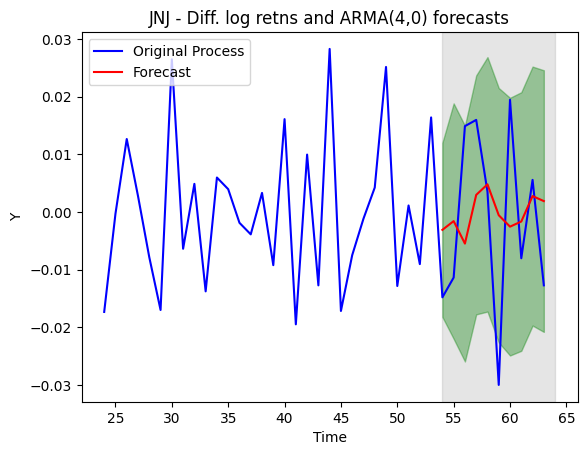

MSE over first 10 points of Y_test and Y_pred:
MSE(Y_pred[:10],Y_test[:10]) = 0.00024298581450247288


In [ ]:
plot_forecasts(Y_train = Z_train,
               n_train_plot_pts = 30,
               Y_test = Z_test,
               Y_pred = Z_pred,
               n_forecast_plot_pts = N_test,
               fig_title = 'JNJ - Diff. log retns and ARMA(4,0) forecasts',
               legend_loc = 2,
               Y_pred_conf_int = Z_pred_conf_int,
               plot_confidence_band = True,)

### (6) Forecasting the JNJ close prices

Now it's a matter of transforming the forecast time series back to close prices.

In [ ]:
# Forecasted log returns
Y_pred = np.zeros(shape = (N_test,))
Y_pred[0] =Y_train[-1]+Z_pred[0]

for i in range(N_test-1):
    Y_pred[i+1] = Y_pred[i]+Z_pred[i+1]

In [ ]:
# Confidence interval
Y_pred_conf_int = np.zeros(shape = (N_test,2))
Y_pred_conf_int[0,:] =Y_train[-1]*np.ones(shape=(2,))\
                +Z_pred_conf_int[0,:]

for i in range(N_test-1):
    Y_pred_conf_int[i+1,:] = Z_pred_conf_int[i+1,:]\
                + Y_pred[i]*np.ones(shape=(2,))

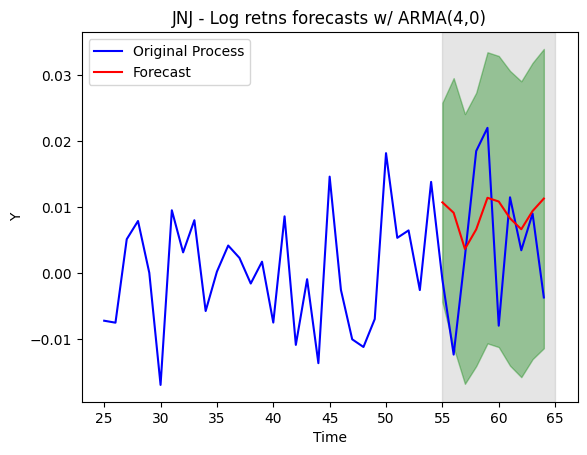

MSE over first 10 points of Y_test and Y_pred:
MSE(Y_pred[:10],Y_test[:10]) = 0.00014527281459874854


In [ ]:
plot_forecasts(Y_train = Y_train,
               n_train_plot_pts = 30,
               Y_test = Y_test,
               Y_pred = Y_pred,
               n_forecast_plot_pts = N_test,
               fig_title = 'JNJ - Log retns forecasts w/ ARMA(4,0)',
               legend_loc = 2,
               Y_pred_conf_int = Y_pred_conf_int,
               plot_confidence_band = True,)

Now we look at the close prices.

In [ ]:
# Close prices arrays of JNJ
X = df_close["JNJ"].to_numpy()
X_train = X[:-N_test]
X_test = X[-N_test:]

# Predictions
X_pred = np.zeros(shape = (N_test,))
X_pred[0] = X_train[-1]*np.exp(Y_pred[0])
for i in range(1,N_test):
    X_pred[i] = X_train[i-1]*np.exp(Y_pred[i])

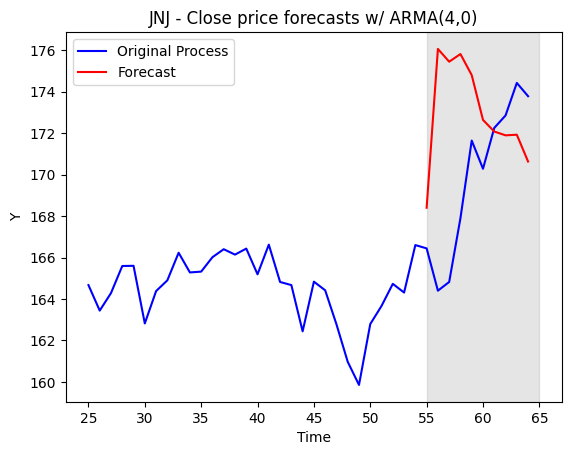

MSE over first 10 points of Y_test and Y_pred:
MSE(Y_pred[:10],Y_test[:10]) = 34.789957469737324


In [ ]:
plot_forecasts(Y_train = X_train,
               n_train_plot_pts = 30,
               Y_test = X_test,
               Y_pred = X_pred,
               n_forecast_plot_pts = N_test,
               fig_title = 'JNJ - Close price forecasts w/ ARMA(4,0)',
               legend_loc = 2,
               Y_pred_conf_int = None,
               plot_confidence_band = False,)

## ARIMA forecast

We'll use two ARIMA implementations to fit the previous example, the statsmodels one and pmdarima.auto_arima. 

Ref (Lazy Programmer):
https://deeplearningcourses.com/notebooks/dWpuzIAACHK74pAsnXdEUg/--08SwdGNgBRuS_b7HR_Mg

### Loading the data

In [6]:
# Load DJIA file 
df_Alpaca_15min = pd.read_csv(filepath_or_buffer="datasets/Alpaca_DJIA_15min_2208-2211.csv",
                           usecols = ['date', 'open', 'high', 'low', 'close', 'volume', 'tic'])

# Get close price log returns of JNJ
df_returns, df_close = get_daily_stock_returns(df_data = df_Alpaca_15min,
                                               stock_tickers_list = ["JNJ"],
                                               start_date = "2022-08-01",
                                               end_date = "2022-10-31",
                                               log_returns = True,)


<Axes: >

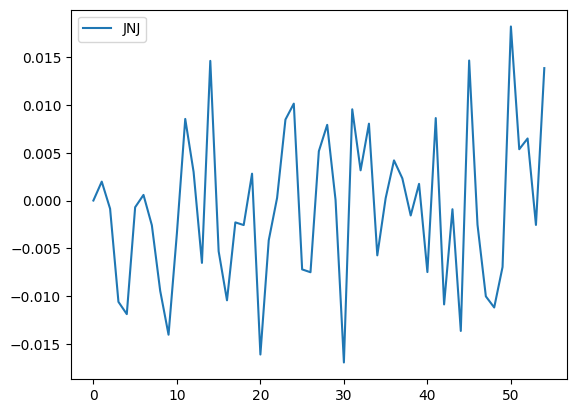

In [7]:
# Get the time series and split into train-test
Y = df_returns["JNJ"].to_numpy()
N_test = 10
Y_train = Y[:-N_test]
Y_test = Y[-N_test:]

# Plot last 20 points of time series
df_returns.iloc[:-N_test].plot()

### ARIMA(4,1,0) with statsmodels

In [15]:
# Instantiate temp model
model = ARIMA(endog = Y_train,
              order=(4, 1, 0))

# Fit the model
model_fit_res = model.fit()

In [16]:
print(model_fit_res.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   55
Model:                 ARIMA(4, 1, 0)   Log Likelihood                 184.824
Date:                Sat, 27 May 2023   AIC                           -359.648
Time:                        06:34:11   BIC                           -349.703
Sample:                             0   HQIC                          -355.812
                                 - 55                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8884      0.127     -7.009      0.000      -1.137      -0.640
ar.L2         -0.7366      0.144     -5.127      0.000      -1.018      -0.455
ar.L3         -0.8123      0.123     -6.591      0.0

In [18]:
# Predictions and confidence intervals
forecast_res = model_fit_res.get_forecast(N_test)
Y_pred = forecast_res.predicted_mean
Y_pred_conf_int = forecast_res.conf_int()

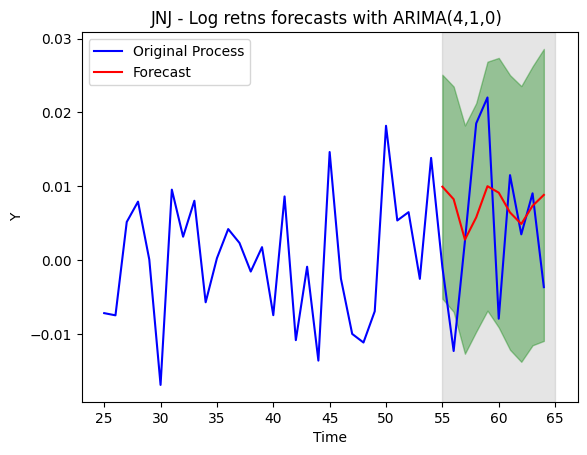

MSE over first 10 points of Y_test and Y_pred:
MSE(Y_pred[:10],Y_test[:10]) = 0.00013274003412171298


In [19]:
plot_forecasts(Y_train = Y_train,
               n_train_plot_pts = 30,
               Y_test = Y_test,
               Y_pred = Y_pred,
               n_forecast_plot_pts = N_test,
               fig_title = 'JNJ - Log retns forecasts with ARIMA(4,1,0) ',
               legend_loc = 2,
               Y_pred_conf_int = Y_pred_conf_int,
               plot_confidence_band = True,)

In [20]:
# Close prices arrays of JNJ
X = df_close["JNJ"].to_numpy()
X_train = X[:-N_test]
X_test = X[-N_test:]

# Predictions
X_pred = np.zeros(shape = (N_test,))
X_pred[0] = X_train[-1]*np.exp(Y_pred[0])
for i in range(1,N_test):
    X_pred[i] = X_train[i-1]*np.exp(Y_pred[i])

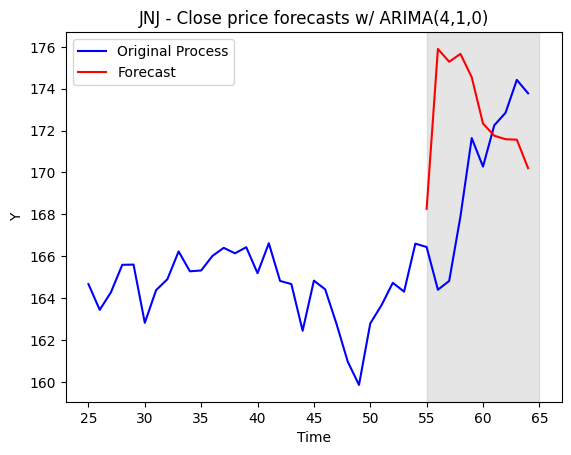

MSE over first 10 points of Y_test and Y_pred:
MSE(Y_pred[:10],Y_test[:10]) = 34.073987294202425


In [21]:
plot_forecasts(Y_train = X_train,
               n_train_plot_pts = 30,
               Y_test = X_test,
               Y_pred = X_pred,
               n_forecast_plot_pts = N_test,
               fig_title = 'JNJ - Close price forecasts w/ ARIMA(4,1,0)',
               legend_loc = 2,
               Y_pred_conf_int = None,
               plot_confidence_band = False,)

### Auto ARIMA function

I'm mimicking Lazy Progammer here. The documentation:

https://alkaline-ml.com/pmdarima/modules/generated/pmdarima.arima.auto_arima.html

In [22]:
from pmdarima import auto_arima

In [32]:
# Fit the data
model = auto_arima(Y_train,
                   trace=True,
                   suppress_warnings=True,
                   seasonal=False,)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=-363.812, Time=1.18 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-369.588, Time=0.09 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-367.598, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=-367.600, Time=0.09 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-365.588, Time=0.14 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-368.158, Time=0.09 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0]          
Total fit time: 1.672 seconds


Totally unexpected, and I do not like the results. I think it's better to monitor this function a little. Trying with more parameters:

In [35]:
# Fit the data
model = auto_arima(Y_train,
                   trace=True,
                   d = 1,
                   start_p = 3,
                   suppress_warnings=True,
                   seasonal=False,)

Performing stepwise search to minimize aic
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-354.394, Time=1.44 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-323.135, Time=0.17 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-332.773, Time=0.34 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.84 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-325.109, Time=0.09 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-347.724, Time=1.51 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-356.273, Time=1.23 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-353.206, Time=1.58 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-351.335, Time=1.01 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=-354.143, Time=1.83 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-333.538, Time=0.18 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=-358.174, Time=1.37 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=-356.404, Time=0.99 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=-353.854, Time=1.37 sec
 ARIMA(4,1,0)(0,0,0)[0]             : 

In [36]:
# Summary
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   55
Model:               SARIMAX(4, 1, 0)   Log Likelihood                 184.824
Date:                Sat, 27 May 2023   AIC                           -359.648
Time:                        06:56:55   BIC                           -349.703
Sample:                             0   HQIC                          -355.812
                                 - 55                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8884      0.127     -7.009      0.000      -1.137      -0.640
ar.L2         -0.7366      0.144     -5.127      0.000      -1.018      -0.455
ar.L3         -0.8123      0.123     -6.591      0.000      -1.054      -0.571
ar.L4         -0.3829      0.124     -3.081      0.002      -0.626      -0.139
sigma2      5.995e-05   1.15e-05      5.222      0.000    3.74e-05    8.24e-05
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):                 1.39
Prob(Q):                              0.88   Prob(JB):                         0.50
Heteroskedasticity (H):               0.96   Skew:                             0.38
Prob(H) (two-sided):                  0.94   Kurtosis:                         3.18
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Here is the forecasting method. Docs:

https://alkaline-ml.com/pmdarima/modules/generated/pmdarima.arima.ARIMA.html#pmdarima.arima.ARIMA.predict


In [37]:
# Make forecasts
Y_pred, Y_pred_conf_int = model.predict(n_periods=N_test, return_conf_int=True)

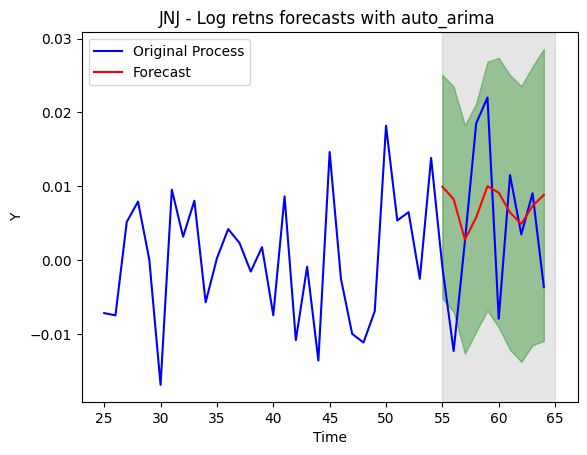

MSE over first 10 points of Y_test and Y_pred:
MSE(Y_pred[:10],Y_test[:10]) = 0.00013274003412171298


In [38]:
plot_forecasts(Y_train = Y_train,
               n_train_plot_pts = 30,
               Y_test = Y_test,
               Y_pred = Y_pred,
               n_forecast_plot_pts = N_test,
               fig_title = 'JNJ - Log retns forecasts with auto_arima ',
               legend_loc = 2,
               Y_pred_conf_int = Y_pred_conf_int,
               plot_confidence_band = True,)

In [39]:
# Close prices arrays of JNJ
X = df_close["JNJ"].to_numpy()
X_train = X[:-N_test]
X_test = X[-N_test:]

# Predictions
X_pred = np.zeros(shape = (N_test,))
X_pred[0] = X_train[-1]*np.exp(Y_pred[0])
for i in range(1,N_test):
    X_pred[i] = X_train[i-1]*np.exp(Y_pred[i])

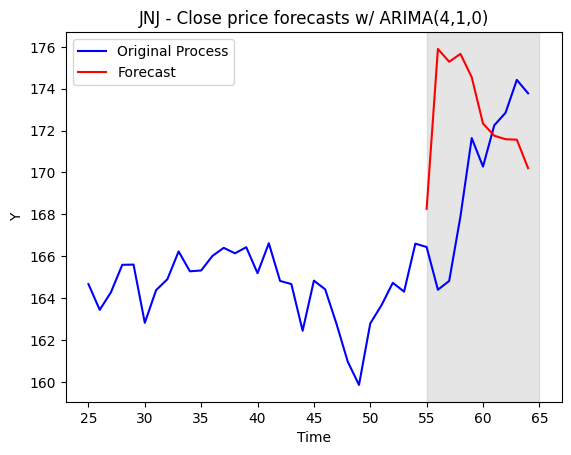

MSE over first 10 points of Y_test and Y_pred:
MSE(Y_pred[:10],Y_test[:10]) = 34.073987294202425


In [40]:
plot_forecasts(Y_train = X_train,
               n_train_plot_pts = 30,
               Y_test = X_test,
               Y_pred = X_pred,
               n_forecast_plot_pts = N_test,
               fig_title = 'JNJ - Close price forecasts w/ ARIMA(4,1,0)',
               legend_loc = 2,
               Y_pred_conf_int = None,
               plot_confidence_band = False,)

In [33]:
# Fit the data
model_X = auto_arima(X_train,
                   trace=True,
                   suppress_warnings=True,
                   seasonal=True,)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=1.67 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=191.229, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=193.196, Time=0.10 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=193.184, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=189.835, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=1.24 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 3.329 seconds


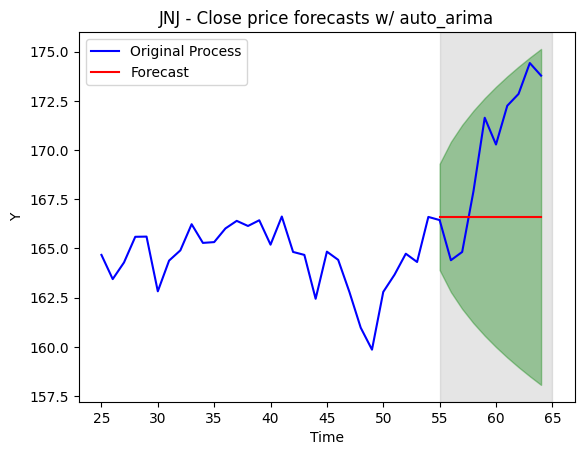

MSE over first 10 points of Y_test and Y_pred:
MSE(Y_pred[:10],Y_test[:10]) = 23.23578


In [34]:
# Predict prices
Z_pred, Z_conf_int = model_X.predict(n_periods=N_test, return_conf_int=True)

# Plot results
plot_forecasts(Y_train = X_train,
               n_train_plot_pts = 30,
               Y_test = X_test,
               Y_pred = Z_pred,
               n_forecast_plot_pts = N_test,
               fig_title = 'JNJ - Close price forecasts w/ auto_arima',
               legend_loc = 2,
               Y_pred_conf_int = Z_conf_int,
               plot_confidence_band = True,)

# DJIA: Stationarity of log returns

I'm curious to see what happens with the log returns of all stock prices in the DJIA CSV.

In [5]:
# Load DJIA file 
df_Alpaca_15min = pd.read_csv(filepath_or_buffer="datasets/Alpaca_DJIA_15min_2208-2211.csv",
                           usecols = ['date', 'open', 'high', 'low', 'close', 'volume', 'tic'])

ticker_list = list(df_Alpaca_15min.tic.unique())

In [6]:
len(ticker_list)

30

In [7]:
# Get close price log returns of JNJ
df_returns, df_close = get_daily_stock_returns(df_data = df_Alpaca_15min,
                                               stock_tickers_list = ticker_list,
                                               start_date = "2022-08-01",
                                               end_date = "2022-10-31",
                                               log_returns = True,)


In [17]:
# Initialize results dataframe
df_results = pd.DataFrame(index = range(len(ticker_list)),
                          columns = ["Ticker", "LogRets_Stationary", "ADF_p_val", "ADF_n_lags", "d"]
                         )

In [26]:
# Check stationarity for all
for i in range(len(ticker_list)):
    # Ticker
    tic = ticker_list[i]
    df_results["Ticker"].iloc[i] = tic
    # Log returns series
    Y = df_returns[tic].to_numpy()
    # Apply ADF test
    Y_ADF, Y_ADF_pval, Y_n_lags, _, _, _ = adfuller(Y)
    df_results["ADF_p_val"].iloc[i] = Y_ADF_pval
    df_results["ADF_n_lags"].iloc[i] = Y_n_lags
    # Initializations for integration order
    Y_is_stationary = (Y_ADF_pval <= 0.05)
    df_results["LogRets_Stationary"].iloc[i] = Y_is_stationary
    int_order_d = 0
    found_d = Y_is_stationary
    Z = Y.copy()
    # Find integration order
    while not found_d and (int_order_d<=10):
        # Difference the series once more
        Z = np.diff(Z)
        int_order_d += 1
        # Apply ADF to differenced series
        Z_ADF, Z_ADF_pval, Z_n_lags, _, _, _ = adfuller(Z)
        found_d = (Z_ADF_pval <= 0.05)
    
    # Record integration order
    if found_d:
        df_results["d"].iloc[i] = int_order_d
    else:
        df_results["d"].iloc[i] = "> 10"

In [28]:
df_results.head(30)

,Ticker,LogRets_Stationary,ADF_p_val,ADF_n_lags,d
0,AAPL,True,0.0,0,0
1,AMGN,True,0.0,0,0
2,AXP,True,0.0,0,0
3,BA,True,0.0,0,0
4,CAT,True,0.0,0,0
5,CRM,True,0.0,0,0
6,CSCO,True,0.0,0,0
7,CVX,True,0.0,0,0
8,DIS,True,0.0,0,0
9,DOW,True,0.0,0,0
